<a href="https://colab.research.google.com/github/Lokallu/pyfx/blob/master/Time_Series_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on website:
https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb#scrollTo=VlJYi3_HXcw8

Choose Tensorflow 2.x

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import pandas as pd
import tensorflow as tf

In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Params

In [0]:
TRAIN_SPLIT = 300000
BATCH_SIZE = 256

past_history = 720
future_target = 72
STEP = 6  # step between each data within past_window

EVALUATION_INTERVAL = 200
VALIDATION_STEPS = 50

EPOCHS = 10
BUFFER_SIZE = 10000

Setting seed to ensure reproducibility.

In [0]:
tf.random.set_seed(13)

# Gathering Data

### Download

In [0]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [8]:
df = pd.read_csv(csv_path)
df.head()

             Date Time  p (mbar)  T (degC)  ...  wv (m/s)  max. wv (m/s)  wd (deg)
0  01.01.2009 00:10:00    996.52     -8.02  ...      1.03           1.75     152.3
1  01.01.2009 00:20:00    996.57     -8.41  ...      0.72           1.50     136.1
2  01.01.2009 00:30:00    996.53     -8.51  ...      0.19           0.63     171.6
3  01.01.2009 00:40:00    996.51     -8.31  ...      0.34           0.50     198.0
4  01.01.2009 00:50:00    996.51     -8.27  ...      0.32           0.63     214.3

[5 rows x 15 columns]


### Feature selection

In [9]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

features = df[features_considered]
features.index = df['Date Time']
features.head()

                     p (mbar)  T (degC)  rho (g/m**3)
Date Time                                            
01.01.2009 00:10:00    996.52     -8.02       1307.75
01.01.2009 00:20:00    996.57     -8.41       1309.80
01.01.2009 00:30:00    996.53     -8.51       1310.24
01.01.2009 00:40:00    996.51     -8.31       1309.19
01.01.2009 00:50:00    996.51     -8.27       1309.00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a110a1dd8>,
      dtype=object)

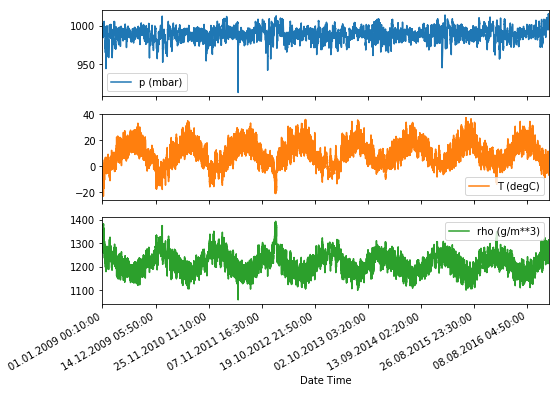

In [10]:
features.plot(subplots=True)

# Feature eng.

### Norm

In [0]:
dataset = features.values
data_mean = dataset.mean(axis=0)
data_std = dataset.std(axis=0)

dataset = (dataset - data_mean) / data_std

### Windowing

In [12]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i - history_size, i, step)
    data.append(dataset[indices])
    labels.append(target[i:i + target_size])

  return np.array(data), np.array(labels)


x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

# window size = 720 / 6 step, 3 features
print('Single window of past history : {}'.format(x_train_multi[0].shape))
# target size = future_target = 72
print('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


### tf.data

In [0]:
train_data_multi = tf.data.Dataset.from_tensor_slices(
    (x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

# Model

### Def

In [20]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[1:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(future_target))

multi_step_model.compile(
    optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

multi_step_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 120, 32)           4608      
_________________________________________________________________
lstm_7 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_3 (Dense)              (None, 72)                1224      
Total params: 8,968
Trainable params: 8,968
Non-trainable params: 0
_________________________________________________________________


### Output shape

In [15]:
for x, y in val_data_multi.take(1):
  print(multi_step_model.predict(x).shape)

(256, 72)


# Train

In [16]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=VALIDATION_STEPS)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 54s 268ms/step - loss: 0.5464 - val_loss: 0.3102
Epoch 2/10
200/200 [==============================] - 50s 249ms/step - loss: 0.3410 - val_loss: 0.2818
Epoch 3/10
200/200 [==============================] - 49s 245ms/step - loss: 0.3167 - val_loss: 0.2666
Epoch 4/10
200/200 [==============================] - 49s 246ms/step - loss: 0.2697 - val_loss: 0.2348
Epoch 5/10
200/200 [==============================] - 49s 246ms/step - loss: 0.2127 - val_loss: 0.2090
Epoch 6/10
200/200 [==============================] - 51s 255ms/step - loss: 0.2182 - val_loss: 0.2259
Epoch 7/10
200/200 [==============================] - 54s 269ms/step - loss: 0.2115 - val_loss: 0.2227
Epoch 8/10
200/200 [==============================] - 53s 266ms/step - loss: 0.2054 - val_loss: 0.2059
Epoch 9/10
200/200 [==============================] - 53s 266ms/step - loss: 0.2077 - val_loss: 0.2022
Epoch 10/10
200/200 [=========

# Resluts

### Loss

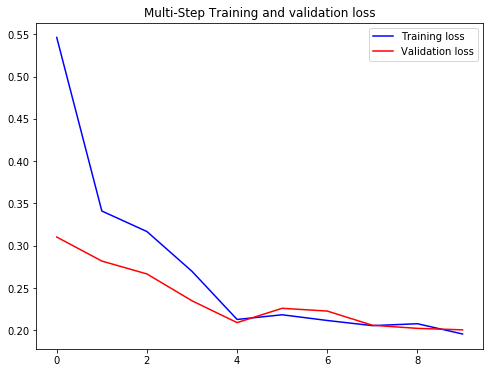

In [17]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()


plot_train_history(multi_step_history,
                   'Multi-Step Training and validation loss')

### Predictions

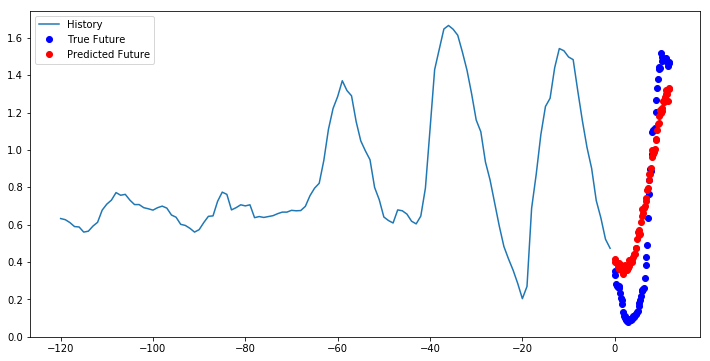

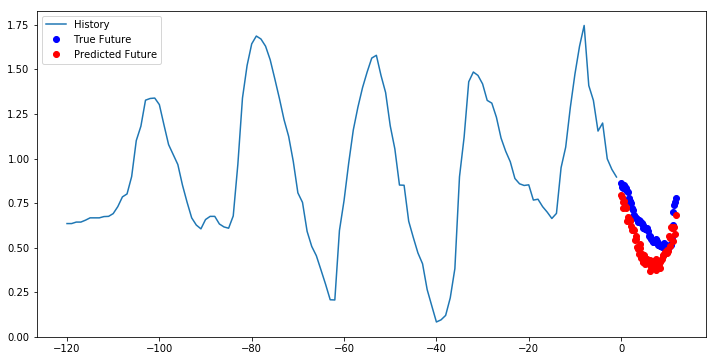

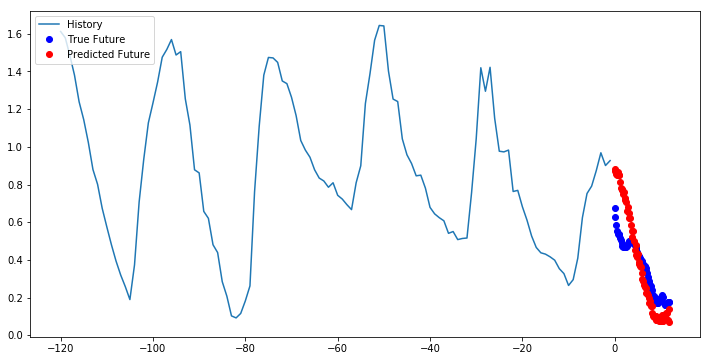

In [18]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps


def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out) / STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out) / STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])
